# Plastic hinges

Click {fa}`rocket` --> {guilabel}`Live Code` on the top right corner of this screen to investigate some plasticity!

In [ ]:
import micropip
await micropip.install("ipympl")

In [1]:
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import numpy as np
import sympy as sym

import ipywidgets as widgets

%matplotlib widget

In [2]:
fy = sym.S(235*10**6)
E = sym.S(210*10**9)
b = sym.nsimplify(1/10)
h = sym.nsimplify(3/10)
c = sym.symbols('c',positive=True)
Izz = b * h ** 3 /12 - (b * c **3 / 12)
eps_y = fy/E
kappa_e = eps_y / (h/2)
M_el = fy * Izz / (h / 2)

In [3]:
kappa = sym.symbols('kappa',positive=True)
k = sym.symbols('k',positive=True)
Izz_2 = b * k ** 3 /12 - (b * sym.Piecewise((c,c<k),(k,c>=k)) **3 / 12)
M_el_2 = fy * Izz_2 / (k / 2)
d = sym.Piecewise((k, k > c), (c, k <= c))
R_pl = b * ( h / 2 - d / 2) * fy
a = (h + d) / 2
M_pl = R_pl * a

M_el_2 = M_el_2.subs(k,kappa_e / kappa * h)
M_pl = M_pl.subs(k,kappa_e / kappa * h)
M_tot = M_el_2 + M_pl
alpha = (M_tot / M_el)
alpha = alpha.subs(kappa,kappa_e*1000000000)

M_pl_nump = sym.lambdify((kappa,c),M_pl)
M_el_nump = sym.lambdify(c,M_el)
M_tot_nump = sym.lambdify((kappa,c),M_tot)
alpha_nump = sym.lambdify(c,alpha)

In [6]:
def solve_kappa(kappa_list,M_list, value):
    idx = (np.abs(M_list - value)).argmin()
    return kappa_list[idx]

interactive(children=(FloatSlider(value=0.0, description='Load', max=1.0, step=0.01), FloatSlider(value=0.0, d…

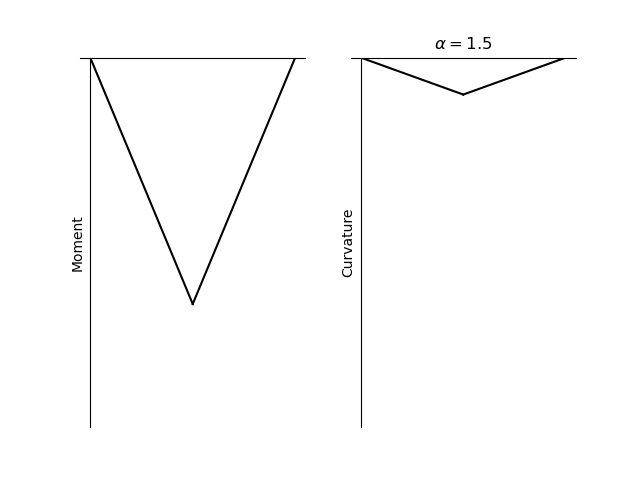

In [9]:
fig = plt.figure()
fig.tight_layout()
ax1 = fig.add_subplot(1,2,1)

ax2 = fig.add_subplot(1,2,2)


M_mid_slider = widgets.FloatSlider(value=0, min=0, max=1, step=0.01,description='Load')
c_slider = widgets.FloatSlider(value=0, min=0, max=h*0.9999, step=0.01, description='Gap (m) in cross section:')

def update_plot(M_mid, c_nump):
    ax1.clear()  # Clear the existing plot
    ax2.clear()
    M_el_max = M_el_nump(c_nump)

    M_pl_max = M_pl_nump(c=c_nump,kappa = float(kappa_e)*10000000)
    M_mid = M_el_max + (M_pl_max - M_el_max) * M_mid

    k_linspace = np.linspace(float(kappa_e),float(kappa_e)*10,1000)
    M_linspace = M_tot_nump(kappa = k_linspace, c = c_nump)
    kappa_el_max = M_el_max/(E*Izz.subs(c,c_nump))
    kappa_pl_max = max(k_linspace)

    
    x_elastic_1 = np.array([0,2.5 - max(2.5 - 2.5 * M_el_max / M_mid,0)])
    M_elastic_1 = np.array([0,M_el_max])
    kappa_1 = np.array([0,kappa_el_max])
    x_elastic_2 = np.array([2.5 + max(2.5 - 2.5 * M_el_max / M_mid,0),5])
    M_elastic_2 = np.array([M_el_max,0])
    kappa_2 = np.array([kappa_el_max,0])
    x_plastic = np.array([2.5 - max(2.5 - 2.5 * M_el_max / M_mid,0),2.5,2.5 + max(2.5 - 2.5 * M_el_max / M_mid,0)])
    M_plastic = np.array([M_el_max,M_mid,M_el_max])
    ax1.plot(x_elastic_1,M_elastic_1,color='black')
    ax1.plot(x_plastic,M_plastic,color='red')
    ax1.plot(x_elastic_2,M_elastic_2,color='black')
    ax1.set_ylim(0,M_pl_max)
    ax1.invert_yaxis()
    ax1.spines['right'].set_color('none')
    ax1.spines['top'].set_color('none')
    ax1.spines['left'].set_position('zero')
    ax1.spines['bottom'].set_position('zero')
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.set_ylabel('Moment')

    x_plastic_1 = np.linspace(2.5 - max(2.5 - 2.5 * M_el_max / M_mid,0),2.5,100)
    x_plastic_2 = np.linspace(2.5,2.5 + max(2.5 - 2.5 * M_el_max / M_mid,0),100)
    M_plastic_1 = np.linspace(M_el_max,M_mid,100)
    M_plastic_2 = np.linspace(M_mid,M_el_max,100)
    kappa_plastic_1 = []
    kappa_plastic_2 = []
    for moment in M_plastic_1:
        kappa_plastic_1.append(solve_kappa(k_linspace,M_linspace,moment))
    for moment in M_plastic_2:
        kappa_plastic_2.append(solve_kappa(k_linspace,M_linspace,moment))
    kappa_pl_max = solve_kappa(k_linspace,M_linspace,M_pl_max)

    ax2.plot(x_elastic_1,kappa_1,color='black')
    ax2.plot(x_plastic_1,kappa_plastic_1,color='red')
    ax2.plot(x_plastic_2,kappa_plastic_2,color='red')
    ax2.plot(x_elastic_2,kappa_2,color='black')
    ax2.set_ylim([0,kappa_pl_max])
    ax2.invert_yaxis()
    ax1.spines['right'].set_color('none')
    ax1.spines['top'].set_color('none')
    ax1.set_xticklabels([])
    ax2.spines['right'].set_color('none')
    ax2.spines['top'].set_color('none')
    ax2.spines['left'].set_position('zero')
    ax2.spines['bottom'].set_position('zero')
    ax2.set_xticklabels([])
    ax2.set_yticklabels([])
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax2.set_ylabel('Curvature')
    title = r'$\alpha=$'+str(np.round(alpha_nump(c = c_nump),3))
    ax2.set_title(title)
    plt.draw()

widgets.interact(update_plot, M_mid = M_mid_slider, c_nump = c_slider);